<div class="alert alert-block alert-info">
⚠️All notebooks should start with the following cell ⚠️.
<br>
<br>
This will ensure that the notebook is set in the correct working directory and that all internal modules can be loaded without setting an entry point.
</div>

In [1]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /workspaces/fil-rouge-pollinisateurs/notebooks
Current working directory:  /workspaces/fil-rouge-pollinisateurs


Setup notebook

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [3]:
path = "data/temporary_data/spipoll.csv"

In [4]:
data = pd.read_csv(path)

/tmp/ipykernel_19322/822284616.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# Data viz

## General Bias in the data

In [5]:
restricted_vars = [
    "collection_id",
    "plante_sc",
    "plante_fr",
    "insecte_sc",
    "insecte_fr",
    "temperature",
    "vent",
    "latitude",
    "longitude",
    "nebulosite",
    "collection_heure_debut",
]
df = data[restricted_vars].copy()

In [6]:
var_interet = df["insecte_fr"]

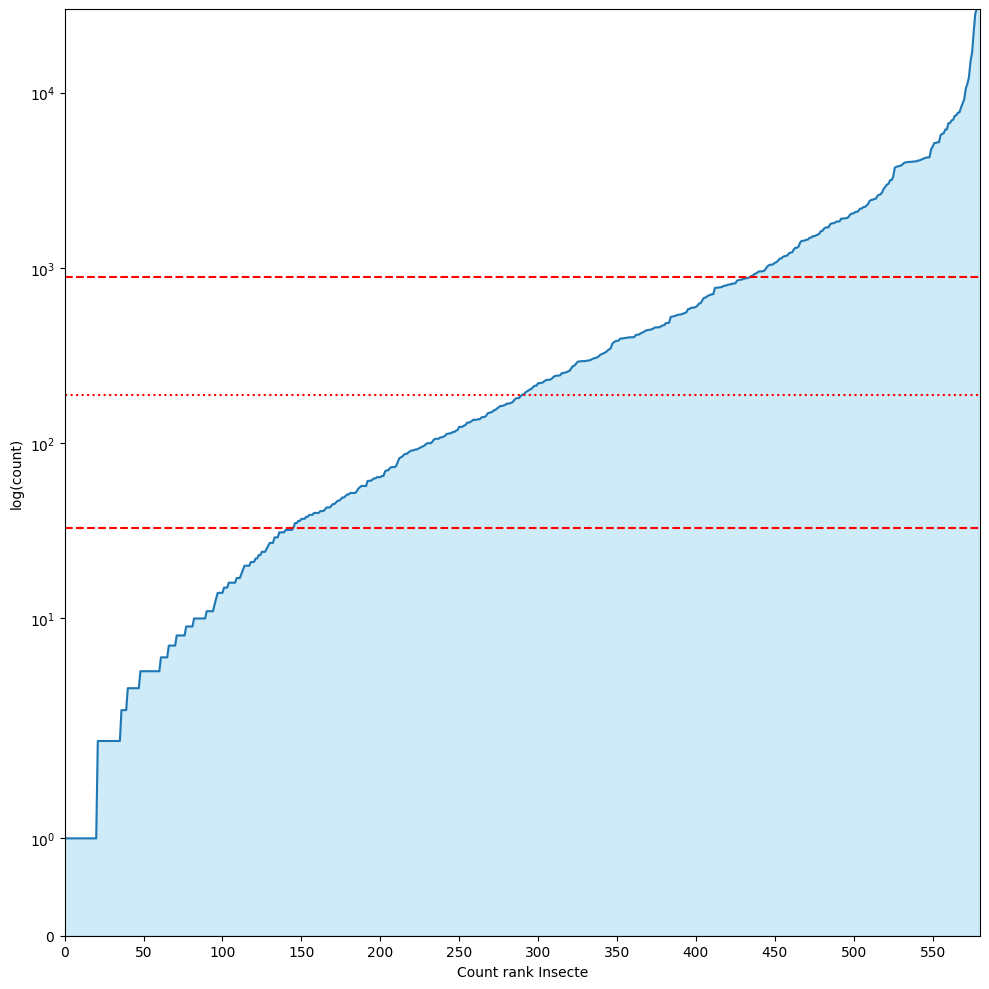

In [8]:
plt.figure(figsize=(10, 10))
x_values = var_interet.dropna().value_counts().index
y_values = var_interet.dropna().value_counts().values[::-1]
sns.lineplot(x=x_values, y=y_values)

# Fill the area under the curve
plt.fill_between(x_values, y_values, color="skyblue", alpha=0.4)

# Put an xtick each 1000 unique values
plt.xticks(range(0, len(var_interet.value_counts()), 50))
# Instead of the label of the xtick, put the position of the xtick
plt.gca().set_xticklabels(range(0, len(var_interet.value_counts()), 50))

# Put a line on the quartiles
plt.axhline(y=var_interet.value_counts().quantile(0.25), color="red", linestyle="--")
plt.axhline(y=var_interet.value_counts().quantile(0.50), color="red", linestyle=":")
plt.axhline(y=var_interet.value_counts().quantile(0.75), color="red", linestyle="--")

plt.ylim(0, 30000)
plt.xlim(0, len(var_interet.value_counts()))
plt.yscale("symlog")
plt.ylabel("log(count)")
plt.xlabel("Count rank Insecte")
plt.tight_layout()
plt.show()

In [9]:
counts = df["insecte_sc"].dropna().value_counts().sort_index()

1/4 des données est très peu représenté sur l'attribut `insecte_sc` `insecte_fr` 

In [ ]:
print("insecte_sc")
display(df["insecte_sc"].value_counts().describe())
print("insecte_fr")
display(df["insecte_fr"].value_counts().describe())
# print(
#     f"Proportion NA insecte_SC: {df['insecte_sc'].isna().sum() / len(df['insecte_sc']) * 100:.2f}%"
# )
# print(
#     f"Proportion NA insecte_FR: {df['insecte_fr'].isna().sum() / len(df['insecte_fr']) * 100:.2f}%"
# )

In [ ]:
# print(df["insecte_sc"].value_counts().head(100).to_dict())

### Visualisation de l'importance de la temporalité

/tmp/ipykernel_19322/847529961.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Axes: xlabel='collection_heure_debut', ylabel='Density'>

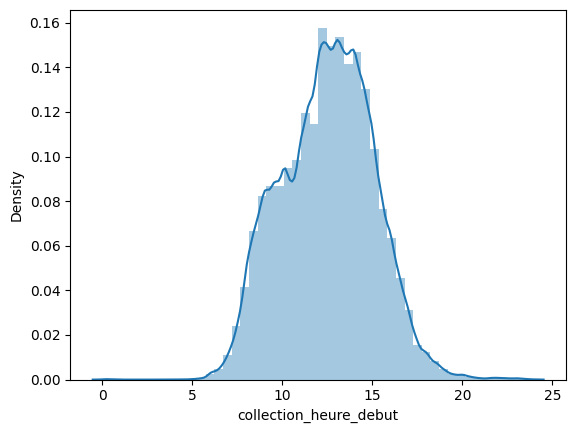

In [12]:
# get samples where collection_heure_debut is between 18 and 08
# knowing data is in this shape  2019-06-12 12:20:00


df["collection_heure_debut"] = pd.to_datetime(df["collection_heure_debut"])

# plot the distribution of the collection_heure_debut avec les minutes et les heures en x
# Aggreger collection_id

sns.distplot(
    df["collection_heure_debut"].dt.hour + df["collection_heure_debut"].dt.minute / 60
)